# Import Modules

In [1]:
import pandas as pd
import numpy as np
import os
import cv2
import glob
import matplotlib.pyplot as plt
import warnings
import tensorflow as tf
from tensorflow.keras import backend as B
from tensorflow.keras.applications import MobileNet
from tensorflow.keras.optimizers import SGD, Adam
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.layers import Dense, Flatten, Dropout, Activation
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.preprocessing.image import img_to_array, ImageDataGenerator
from tensorflow.keras.applications.mobilenet import preprocess_input
from tensorflow.keras.callbacks import Callback

from ipynb.fs.full.utils import *

# Variables Initialization and Data Description

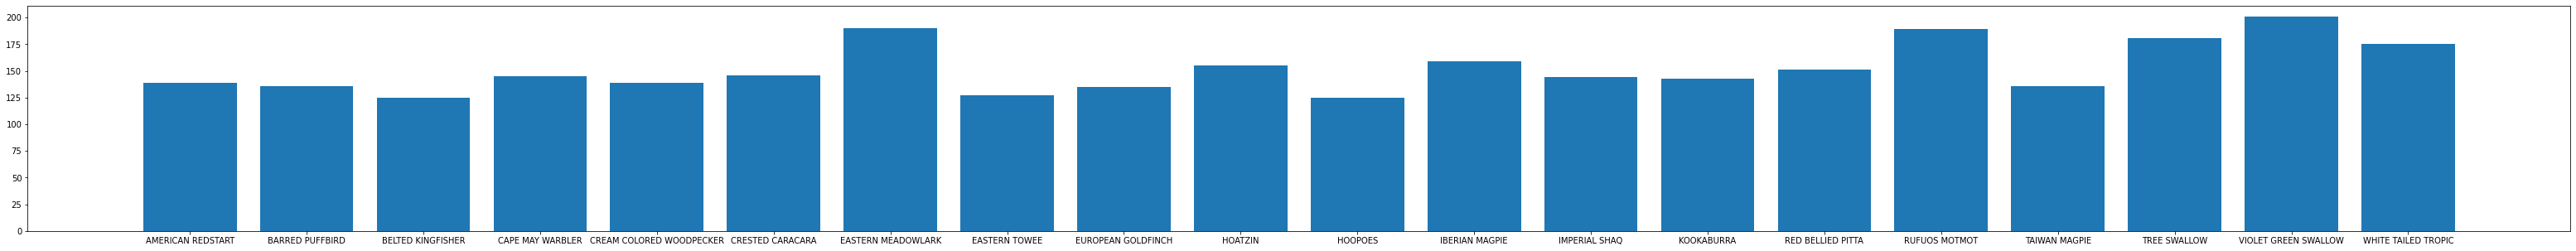

In [2]:
train_path = './dataset/20train'
test_path = './dataset/20test'
valid_path = './dataset/20valid'
nr_birds = 20

describe_data();

# Prepare Generators

Found 3041 images belonging to 20 classes.
Found 100 images belonging to 20 classes.
Found 100 images belonging to 20 classes.


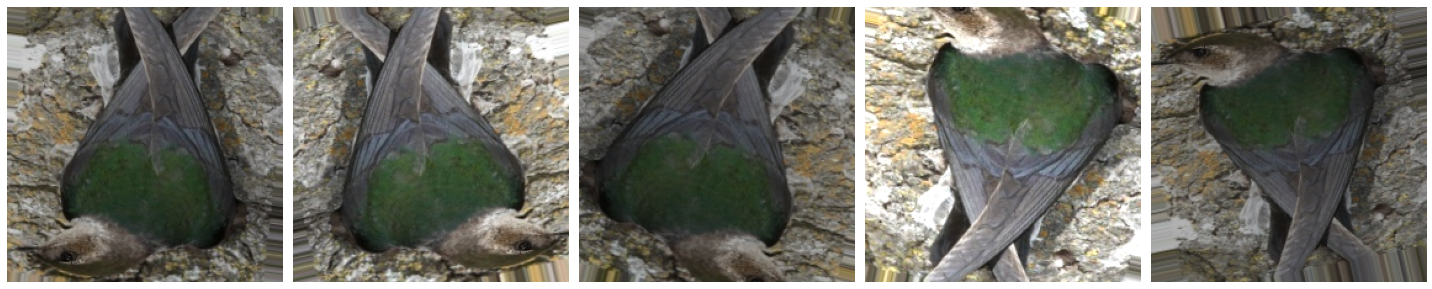

In [3]:
# Data augmentation
train_datagen = ImageDataGenerator(
  rescale=1/255,
  horizontal_flip=True,
  vertical_flip=True,
  rotation_range=15,
  zoom_range=0.1,
  brightness_range=[0.5, 1.5],
)
valid_datagen = ImageDataGenerator(rescale=1/255)
test_datagen = ImageDataGenerator(rescale=1/255)

train_generator = train_datagen.flow_from_directory(
  train_path,
  target_size=(224, 224),
  batch_size=64,
  color_mode='rgb',
  class_mode='categorical',
  shuffle=True
)

validation_generator = valid_datagen.flow_from_directory(
  valid_path,
  target_size=(224, 224),
  batch_size=32,
  color_mode='rgb',
  class_mode='categorical',
  shuffle=False
)

test_generator = test_datagen.flow_from_directory(
  test_path,
  target_size=(224, 224),
  batch_size=32,
  color_mode='rgb',
  class_mode='categorical',
  shuffle=False
  )

def plotImages(images_arr):
  fig, axes = plt.subplots(1, 5, figsize=(20,20))
  axes = axes.flatten()
  for img, ax in zip(images_arr, axes):
      ax.imshow(img)
      ax.axis('off')
  plt.tight_layout()
  plt.show()
    
augmented_images = [train_generator[0][0][0] for i in range(5)]
plotImages(augmented_images)

# Load pre-trained Model, Build model and Train model

In [4]:
base_mobilenet = MobileNet(weights="imagenet", include_top=False, input_shape=(224, 224, 3))

for layer in base_mobilenet.layers:
  layer.trainable = False

# base_mobilenet.trainable = False
base_mobilenet.summary()

new_model = Sequential()
new_model.add(base_mobilenet)

new_model.add(Flatten()) 
new_model.add(Activation('relu'))
new_model.add(Dropout(0.2))
new_model.add(Dense(nr_birds)) 
new_model.add(Activation('softmax'))
new_model.summary()

new_model.compile(SGD(lr=0.0001, momentum=0.9, nesterov=True), loss='categorical_crossentropy', metrics=['accuracy'])

def evaluate(model, optimizer):
  test_loss, test_acc = model.evaluate(test_generator)
  result = "Using " + optimizer + " We obtained: " + "Test Accuracy:", test_acc, "Test Loss:", test_loss
  print(result)
  return result

def lr_scheduler(epoch, lr):
  if epoch < 5:
    return lr
  else:
    return lr * tf.math.exp()
  
class EarlyStoppingByLossVal(Callback):
  def __init__(self, monitor='val_loss', value=0.00001, verbose=0):
    super(Callback, self).__init__()
    self.monitor = monitor
    self.value = value
    self.verbose = verbose
      

  def on_epoch_end(self, epoch, logs={}):
    current = logs.get(self.monitor)
    if current is None:
        warnings.warn("Early stopping requires %s available!" % self.monitor, RuntimeWarning)

    if current < self.value:
        if self.verbose > 0:
            print("Epoch %05d: early stopping THR" % epoch)
        self.model.stop_training = True
        
checkpointer = ModelCheckpoint(filepath='./checkpoints/mobile_net_birds.model.h5', save_best_only=True)

2022-05-09 03:23:46.912342: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2022-05-09 03:23:46.912604: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


Metal device set to: Apple M1

systemMemory: 8.00 GB
maxCacheSize: 2.67 GB

Model: "mobilenet_1.00_224"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 conv1 (Conv2D)              (None, 112, 112, 32)      864       
                                                                 
 conv1_bn (BatchNormalizatio  (None, 112, 112, 32)     128       
 n)                                                              
                                                                 
 conv1_relu (ReLU)           (None, 112, 112, 32)      0         
                                                                 
 conv_dw_1 (DepthwiseConv2D)  (None, 112, 112, 32)     288       
                                                                 
 conv_dw_1_bn (BatchNormaliz  (None, 1

/Users/shaun/miniforge3/lib/python3.9/site-packages/keras/optimizer_v2/gradient_descent.py:102: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(SGD, self).__init__(name, **kwargs)


In [5]:
SgdHistory = new_model.fit_generator(train_generator, epochs=30, validation_data=validation_generator, verbose=1, callbacks=[checkpointer, EarlyStoppingByLossVal(monitor='val_loss', value=0.001, verbose=1)])
SgdTestResult = evaluate(new_model, "SGD")
B.clear_session()

new_model.compile(Adam(lr=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])
AdamHistory = new_model.fit_generator(train_generator, epochs=30, validation_data=validation_generator, verbose=1, callbacks=[checkpointer, EarlyStoppingByLossVal(monitor='val_loss', value=0.001, verbose=1)])
AdamTestResult = evaluate(new_model, "Adam")

/var/folders/x0/f6tjyw_s7vqbx5gcpvt0z31w0000gn/T/ipykernel_34123/1971245460.py:1: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  SgdHistory = new_model.fit_generator(train_generator, epochs=30, validation_data=validation_generator, verbose=1, callbacks=[checkpointer, EarlyStoppingByLossVal(monitor='val_loss', value=0.001, verbose=1)])


Epoch 1/30


2022-05-09 03:23:48.051834: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2022-05-09 03:23:48.607995: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


48/48 [==============================] - ETA: 0s - loss: 3.0404 - accuracy: 0.3279

2022-05-09 03:24:14.098198: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


48/48 [==============================] - 27s 542ms/step - loss: 3.0404 - accuracy: 0.3279 - val_loss: 0.7629 - val_accuracy: 0.7600
Epoch 2/30
48/48 [==============================] - 32s 655ms/step - loss: 0.9216 - accuracy: 0.7320 - val_loss: 0.4794 - val_accuracy: 0.8700
Epoch 3/30
48/48 [==============================] - 40s 829ms/step - loss: 0.5965 - accuracy: 0.8201 - val_loss: 0.3067 - val_accuracy: 0.9100
Epoch 4/30
48/48 [==============================] - 61s 1s/step - loss: 0.4424 - accuracy: 0.8583 - val_loss: 0.2946 - val_accuracy: 0.9000
Epoch 5/30
48/48 [==============================] - 72s 1s/step - loss: 0.3420 - accuracy: 0.8895 - val_loss: 0.2624 - val_accuracy: 0.9400
Epoch 6/30
48/48 [==============================] - 70s 1s/step - loss: 0.3020 - accuracy: 0.9046 - val_loss: 0.2202 - val_accuracy: 0.9500
Epoch 7/30
48/48 [==============================] - 71s 1s/step - loss: 0.2718 - accuracy: 0.9129 - val_loss: 0.2201 - val_accuracy: 0.9600
Epoch 8/30
48/48 [====

/Users/shaun/miniforge3/lib/python3.9/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)
/var/folders/x0/f6tjyw_s7vqbx5gcpvt0z31w0000gn/T/ipykernel_34123/1971245460.py:6: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  AdamHistory = new_model.fit_generator(train_generator, epochs=30, validation_data=validation_generator, verbose=1, callbacks=[checkpointer, EarlyStoppingByLossVal(monitor='val_loss', value=0.001, verbose=1)])


Epoch 1/30


2022-05-09 03:47:41.251382: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


48/48 [==============================] - ETA: 0s - loss: 0.0875 - accuracy: 0.9707

2022-05-09 03:48:18.491611: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


48/48 [==============================] - 39s 782ms/step - loss: 0.0875 - accuracy: 0.9707 - val_loss: 0.1256 - val_accuracy: 0.9600
Epoch 2/30
48/48 [==============================] - 38s 793ms/step - loss: 0.0742 - accuracy: 0.9760 - val_loss: 0.1088 - val_accuracy: 0.9600
Epoch 3/30
48/48 [==============================] - 38s 785ms/step - loss: 0.0799 - accuracy: 0.9724 - val_loss: 0.1695 - val_accuracy: 0.9600
Epoch 4/30
48/48 [==============================] - 38s 790ms/step - loss: 0.0609 - accuracy: 0.9806 - val_loss: 0.1228 - val_accuracy: 0.9800
Epoch 5/30
48/48 [==============================] - 38s 784ms/step - loss: 0.0542 - accuracy: 0.9836 - val_loss: 0.1186 - val_accuracy: 0.9700
Epoch 6/30
48/48 [==============================] - 38s 784ms/step - loss: 0.0378 - accuracy: 0.9865 - val_loss: 0.1141 - val_accuracy: 0.9700
Epoch 7/30
48/48 [==============================] - 38s 788ms/step - loss: 0.0481 - accuracy: 0.9829 - val_loss: 0.1180 - val_accuracy: 0.9700
Epoch 8/30

# Print test results

In [6]:
print(SgdTestResult)
print(AdamTestResult)

('Using SGD We obtained: Test Accuracy:', 1.0, 'Test Loss:', 0.007518876809626818)
('Using Adam We obtained: Test Accuracy:', 0.9899999499320984, 'Test Loss:', 0.061033155769109726)


# Graphs

/var/folders/x0/f6tjyw_s7vqbx5gcpvt0z31w0000gn/T/ipykernel_34123/992828452.py:15: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


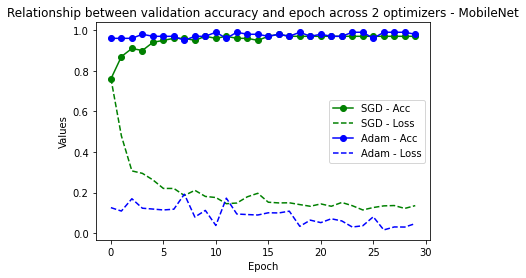

In [17]:
def plotOptimizer():
  fig = plt.figure(facecolor="w")
  plt.plot(SgdHistory.history['val_accuracy'], 'g', marker='o', label="SGD - Acc")
  plt.plot(SgdHistory.history['val_loss'], 'g',  linestyle = 'dashed', label="SGD - Loss")
  plt.plot(AdamHistory.history['val_accuracy'], 'b', marker='o', label="Adam - Acc")
  plt.plot(AdamHistory.history['val_loss'], 'b',  linestyle = 'dashed', label="Adam - Loss")
  
  plt.title('Relationship between validation accuracy and epoch across 2 optimizers - MobileNet')
  plt.xlabel('Epoch')
  plt.ylabel('Values')
  plt.legend()
  return fig

fig = plotOptimizer()
fig.show()

In [8]:
def plot_loss_acc(history, label):
  history_dict = history.history
  loss_values = history_dict["loss"]
  val_loss_values = history_dict["val_loss"]
  acc_values = history_dict["accuracy"]
  val_acc_values = history_dict["val_accuracy"]
  epochs = range(1, len(history_dict["accuracy"]) + 1)

  plt.figure(facecolor="w")
  plt.plot(epochs, loss_values, "b",marker="o", label="train")
  plt.plot(epochs, val_loss_values, "b", label="valid")
  plt.title("Loss - " + label)
  plt.xlabel("Epochs")
  plt.ylabel("Loss")
  plt.legend()
  plt.show()

  plt.figure(facecolor="w")
  plt.plot(epochs, acc_values, "b", marker="o", label="train")
  plt.plot(epochs, val_acc_values, "b", label="valid")
  plt.title("Accuracy - " + label)
  plt.xlabel("Epochs")
  plt.ylabel("Accuracy")
  plt.legend()
  plt.show()

  import numpy as np
  print("best val_acc:", np.max(val_acc_values), "epoch:", np.argmax(val_acc_values))
  print("best val_loss:", np.min(val_loss_values), "epoch:", np.argmin(val_loss_values))

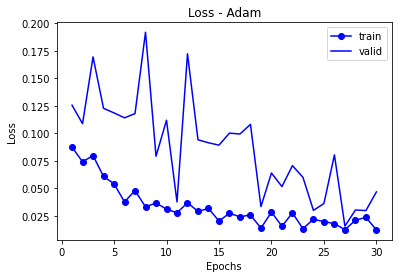

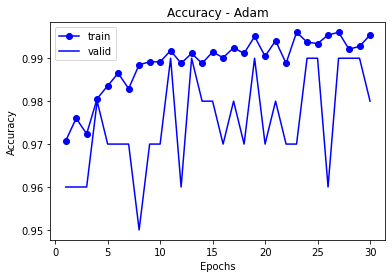

best val_acc: 0.9899999499320984 epoch: 10
best val_loss: 0.015791811048984528 epoch: 26


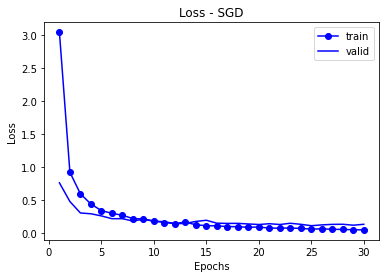

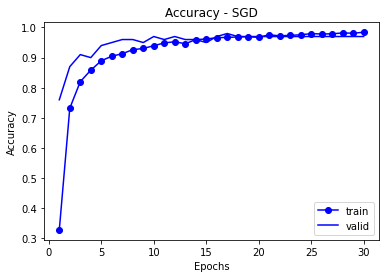

best val_acc: 0.9799999594688416 epoch: 16
best val_loss: 0.11415709555149078 epoch: 24


In [9]:
plot_loss_acc(AdamHistory, "Adam")
plot_loss_acc(SgdHistory, "SGD")

In [11]:
def plotLR(history):
    learning_rate = history.history['lr']
    epochs = range(1, len(learning_rate) + 1)
    fig = plt.figure()
    plt.plot(learning_rate[:40], history.history['val_loss'][:40])
    plt.title('Relationship between loss and learning rate')
    plt.xlabel('Learning Rate')
    plt.ylabel('Validation Loss')
    return(fig)
  
# fig = plotLR(history)
# fig.show()

# Saving Model

In [12]:
new_model.save('./models/mobile_net.h5')

## Running Predictions From Saved Model

In [13]:
def decode (predicted_arr):
  train_path = './dataset/20train'

  all_birds_cat = np.array(list(sorted(os.listdir(train_path))))
  for i, pred in enumerate(predicted_arr):
    confidence = np.round(np.max(pred) * 100, 2)
    return (all_birds_cat[np.argmax(pred)], confidence)


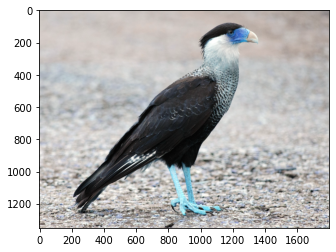

2022-05-09 04:11:50.748291: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


CRESTED CARACARA with 100.0% confidence


In [14]:
import tensorflow as tf

model = tf.keras.models.load_model('./models/mobile_net.h5')

predict_image_path = './dataset/images to test/20.jpg'

plt.imshow(cv2.imread(predict_image_path))
plt.show();

img = load_img(predict_image_path, target_size=(224,224))
img = img_to_array(img)
img = img.reshape((1, img.shape[0], img.shape[1], img.shape[2]))
img = preprocess_input(img)

predictions = model.predict(img)
label, confidence = decode(predictions)

print(label + ' with ' + str(confidence) + '% confidence')

# Resources

Architectures images from [Deep Learning for Vision Systems Book](https://www.manning.com/books/deep-learning-for-vision-systems)